# Assignment 1

In [16]:
# Usual Imports

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.colors as plc
import seaborn as sns
import re

# Commonly used Functions
def gradientbarsh(bars,xdata,cmap):
    
    ax = bars[0].axes
    lim = ax.get_xlim()+ax.get_ylim()
    ax.axis(lim)
    for bar in bars:
        bar.set_facecolor('none')
        x,y = bar.get_xy()
        w, h = bar.get_width(), bar.get_height()
        grad = np.atleast_2d(np.linspace(0,1*w/max(xdata),256)[::-1])
        ax.imshow(grad, extent=[x+w, x, y, y+h], origin='upper', aspect="auto",norm=plc.NoNorm(vmin=0,vmax=1), cmap=plt.get_cmap(cmap), zorder=1)

def gradientbarsv(bars,ydata,cmap):
    ax = bars[0].axes
    lim = ax.get_xlim()+ax.get_ylim()
    ax.axis(lim)
    for bar in bars:
        bar.set_facecolor("none")
        x,y = bar.get_xy()
        w, h = bar.get_width(), bar.get_height()
        grad = np.atleast_2d(np.linspace(0,1*h/max(ydata),256)).T
        ax.imshow(grad, extent=[x,x+w,y,y+h], origin='lower', aspect="auto",norm=plc.NoNorm(vmin=0,vmax=1), cmap=plt.get_cmap(cmap))

def make_cmap(colors):
    nodes = [0.0, 1.0]
    my_cmap = plc.LinearSegmentedColormap.from_list("mycmap", list(zip(nodes, colors)))
    return my_cmap

### Reading the Data

In [17]:
food_inspection_data = pd.read_csv("../data/Food_Inspections.csv")
food_inspection_data[["DBA Name","AKA Name","Facility Type","Risk","Address","City","State","Inspection Type","Results","Violations"]] = food_inspection_data[["DBA Name","AKA Name","Facility Type","Risk","Address","City","State","Inspection Type","Results","Violations"]].apply(lambda x: x.str.upper())
food_inspection_data["Custom Key"] = food_inspection_data["License #"].astype(str) + "|" + food_inspection_data["DBA Name"] + "|" + food_inspection_data["Address"]
food_inspection_data["Custom Key"] = food_inspection_data["Custom Key"].str.strip()
food_inspection_data.head()

,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,City,State,Zip,Inspection Date,Inspection Type,Results,Violations,Latitude,Longitude,Location,Custom Key
0,2563767,CERES' TABLE,CERES' TABLE,2137239.0,RESTAURANT,RISK 1 (HIGH),3124 N BROADWAY,CHICAGO,IL,60657.0,09/15/2022,NON-INSPECTION,NO ENTRY,NaN,41.938412,-87.644492,"(41.93841197166044, -87.64449180403412)",2137239.0|CERES' TABLE|3124 N BROADWAY
1,2563480,FINKI ELEMENTARY ACADEMY,FINKI ELEMENTARY ACADEMY,23541.0,SCHOOL,RISK 1 (HIGH),2332 S WESTERN (2400W),CHICAGO,IL,60608.0,09/12/2022,CANVASS,PASS,NaN,NaN,NaN,NaN,23541.0|FINKI ELEMENTARY ACADEMY|2332 S WESTER...
2,2563279,SH GRILL,SH GRILL,2863054.0,CATERING,RISK 1 (HIGH),167 N GREEN ST,CHICAGO,IL,60607.0,09/06/2022,LICENSE,PASS,NaN,41.885044,-87.648476,"(41.88504417665877, -87.64847590715003)",2863054.0|SH GRILL|167 N GREEN ST
3,2562053,SUBWAY,SUBWAY,2863267.0,RESTAURANT,RISK 1 (HIGH),4351 W ARMITAGE AVE,CHICAGO,IL,60639.0,08/12/2022,LICENSE,PASS,NaN,41.916939,-87.735947,"(41.9169392924408, -87.73594733406117)",2863267.0|SUBWAY|4351 W ARMITAGE AVE
4,2560592,PROVARE CHICAGO,PROVARE CHICAGO,2796734.0,RESTAURANT,RISK 1 (HIGH),1421 W CHICAGO AVE,CHICAGO,IL,60642.0,07/12/2022,CANVASS,PASS,NaN,41.896025,-87.663272,"(41.89602502708334, -87.66327229348566)",2796734.0|PROVARE CHICAGO|1421 W CHICAGO AVE


### Working on Establishments that have failed the inspection, while removing all rows that have no violations 

In [18]:
failed_inspection_data = food_inspection_data[(food_inspection_data["Results"]=="FAIL") & (food_inspection_data["Violations"].notna())].copy()

### Lets find out the top 10 Violations and their counts

In [19]:
def extract_descriptions(violation):
    split_violations = violation.split(sep="|")
    regex_values = []
    pattern = r"(?<=\d\.).*(?= - COMMENTS)"
    for i in split_violations:
        regex = re.search(pattern,i)
        if regex is None:
            string = i.strip()
            string = re.sub(r"(\d{1,3}. )","",string)
            regex_values.append(string)
        else:
            string  = i[regex.start(0):regex.end(0)].strip()
            regex_values.append(string)
    return regex_values
description_extract_df = failed_inspection_data["Violations"].apply(extract_descriptions) # extracting descriptions
after_regex = description_extract_df.iloc[0] 

Let us take a look at a violation before applying our custom regex

In [20]:
failed_inspection_data.iloc[0]["Violations"]

"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL EMPLOYEE; KNOWLEDGE, RESPONSIBILITIES AND REPORTING - COMMENTS: 2-102.14(O) OBSERVED NO EMPLOYEE HEALTH POLICY ON SITE. INSTRUCTED TO PROVIDE. PRIORITY FOUNDATION 7-38-010. | 5. PROCEDURES FOR RESPONDING TO VOMITING AND DIARRHEAL EVENTS - COMMENTS: 2-501.11 OBSERVED NO WRITTEN PROCEDURE NOR ADEQUATE SUPPLIES ON SITE TO PROPERLY RESPOND TO VOMIT AND DIARRHEA EVENTS THAT CAN POTENTIALLY OCCUR INSIDE OF THE FACILITY. INSTRUCTED TO PROVIDE. PRIORITY FOUNDATION 7-38-005. | 10. ADEQUATE HANDWASHING SINKS PROPERLY SUPPLIED AND ACCESSIBLE - COMMENTS: 6-301.14 OBSERVED HAND WASHING SIGNS ARE NEEDED AT ALL OF THE HAND WASHING SINKS LOCATED IN THE FOOD PREP AREA, BAR, AND IN ALL TOILET ROOMS. INSTRUCTED TO PROVIDE. | 21. PROPER HOT HOLDING TEMPERATURES - COMMENTS: 3-501.16(A:1) OBSERVED TIME/TEMPERATURE CONTROL FOR SAFETY FOODS (RICE, DIM SUM) AT IMPROPER HOT HOLDING TEMPERATURES LOCATED INSIDE OF A HOT HOLDING UNIT; ABOUT 2 LBS OF COOKED RICE AT 106F

Let us take a look at a violation after applying our custom regex

In [21]:
after_regex

['MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL EMPLOYEE; KNOWLEDGE, RESPONSIBILITIES AND REPORTING',
 'PROCEDURES FOR RESPONDING TO VOMITING AND DIARRHEAL EVENTS',
 'ADEQUATE HANDWASHING SINKS PROPERLY SUPPLIED AND ACCESSIBLE',
 'PROPER HOT HOLDING TEMPERATURES',
 'PROPER COOLING METHODS USED; ADEQUATE EQUIPMENT FOR TEMPERATURE CONTROL',
 'THERMOMETERS PROVIDED & ACCURATE',
 'FOOD PROPERLY LABELED; ORIGINAL CONTAINER',
 'INSECTS, RODENTS, & ANIMALS NOT PRESENT',
 'INSECTS, RODENTS, & ANIMALS NOT PRESENT',
 'SINGLE-USE/SINGLE-SERVICE ARTICLES: PROPERLY STORED & USED',
 'NON-FOOD/FOOD CONTACT SURFACES CLEAN',
 'PLUMBING INSTALLED; PROPER BACKFLOW DEVICES',
 'TOILET FACILITIES: PROPERLY CONSTRUCTED, SUPPLIED, & CLEANED',
 'GARBAGE & REFUSE PROPERLY DISPOSED; FACILITIES MAINTAINED',
 'PHYSICAL FACILITIES INSTALLED, MAINTAINED & CLEAN',
 'PHYSICAL FACILITIES INSTALLED, MAINTAINED & CLEAN',
 'PHYSICAL FACILITIES INSTALLED, MAINTAINED & CLEAN',
 'ALL FOOD EMPLOYEES HAVE FOOD HANDLER TRAINING',
 

As we can see, our regex has identified only the description codes and has extracted them and created a list. 

Let us now, visualise the top 10 violations

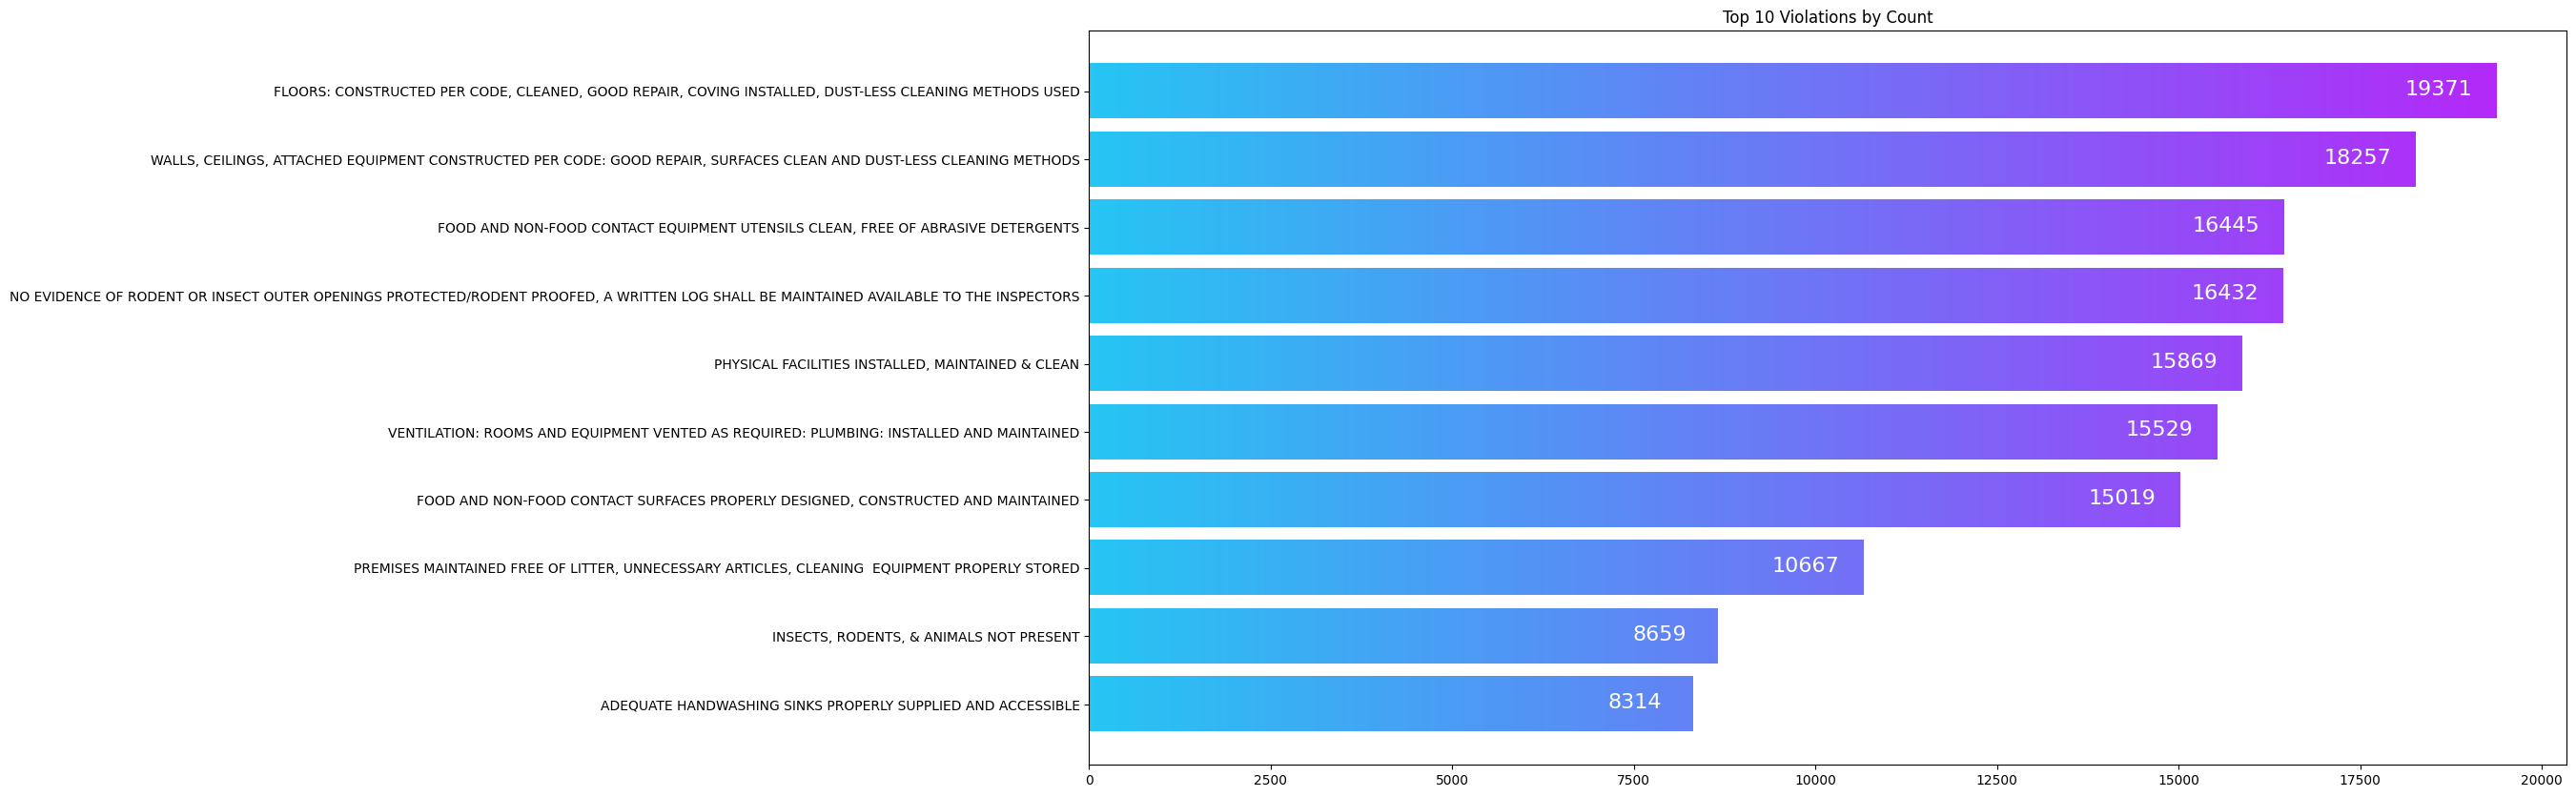

In [22]:
description_extract_df = pd.DataFrame(description_extract_df.explode(),columns=["Violations"]) # exploding  the descriptions
top10 = pd.DataFrame(description_extract_df.value_counts()) # counting the descriptions and creating a dataframe with it
top10.reset_index(inplace=True)
top10 = top10.rename(columns = {'index':'Violations','count':'Count'})
fig,axs = plt.subplots(1,1,figsize=(20,10))
top_violations = axs.barh(top10[:10]["Violations"][::-1],top10[:10]["Count"][::-1])
gradientbarsh(top_violations,top10[:10]["Count"].values,make_cmap(["#26c5f3","#b429f9"]))
for p in axs.patches:
    axs.annotate(f'\n{int(p.get_width())}', (p.get_width()-800, p.get_y()+0.89), ha='center', va='top', color='White', size=16)
axs.set(title="Top 10 Violations by Count")
plt.show()

### Let us now find out the establishments that are repeat offenders and what their most repeated offenses are

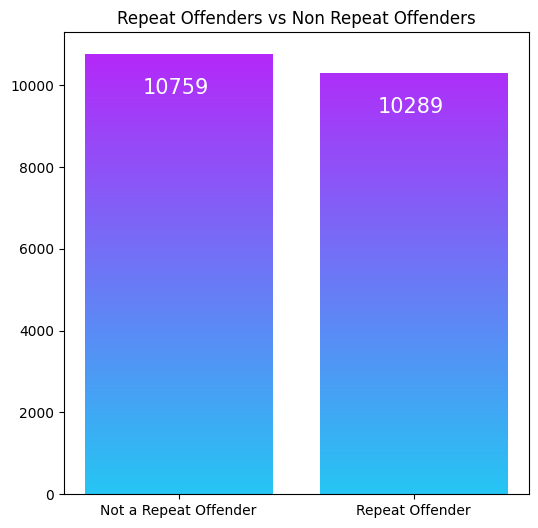

In [23]:
def extract_set_descriptions(violation):
    split_violations = violation.split(sep="|")
    regex_values = set()
    pattern = r"(?<=\d\.).*(?= - COMMENTS)"
    for i in split_violations:
        regex = re.search(pattern,i)
        if regex is None:
            string = i.strip()
            string = re.sub(r"(\d{1,3}. )","",string)
            regex_values.add(string)
        else:
            string  = i[regex.start(0):regex.end(0)].strip()
            regex_values.add(string)
    return list(regex_values)

def return_duplicates(violation_list):
    violation_set  = set()
    dupes = []
    for x in violation_list:
        if x in violation_set:
            dupes.append(x)
        else:
            violation_set.add(x)
    return set(dupes)

repeat_offenders = pd.DataFrame()
repeat_offenders["Custom Key"] = failed_inspection_data["Custom Key"].copy()
repeat_offenders["Custom Key"] = repeat_offenders["Custom Key"].str.strip()
repeat_offenders["Violations_List"] = failed_inspection_data["Violations"].apply(extract_set_descriptions)
Violation_list_grouped = pd.DataFrame(repeat_offenders.groupby(["Custom Key"]).agg({"Violations_List":sum}).reset_index())
count_grouped = pd.DataFrame(repeat_offenders.groupby(["Custom Key"]).count().reset_index())
joined_grouped = Violation_list_grouped.merge(count_grouped,on=["Custom Key"])
joined_grouped.columns = ["Custom Key","Violations","Number of Failed Inspections"]
joined_grouped["Repeat Violations"] = joined_grouped["Violations"].apply(return_duplicates)
joined_grouped["Repeat Offender"] = joined_grouped["Number of Failed Inspections"].apply(lambda x: "Repeat Offender" if x>1 else "Not a Repeat Offender")

bars = joined_grouped["Repeat Offender"].value_counts().reset_index()
fig,axs = plt.subplots(1,1,figsize=(6,6))
repeat_offenders_visual = axs.bar(bars["Repeat Offender"],bars["count"])
gradientbarsv(repeat_offenders_visual,bars["count"].values,make_cmap(["#26c5f3","#b429f9"]))
axs.set(title="Repeat Offenders vs Non Repeat Offenders")
for p in axs.patches:
    axs.annotate(f'\n{int(p.get_height())}', (p.get_x()+0.39, p.get_height()), ha='center', va='top', color='white', size=15)

As we can see the number of restaurants that are repeat offenders (i.e. the restaurants have failed more than 1 inspection) is close to the number of restaurants that have never failed an inspection. This shows that overall the majority of restaurants do not commit any violations.

### Let us now find the restaurants that are repeat offenders and what their repeat violations are

In [24]:
repeat_offender_df = joined_grouped[joined_grouped["Number of Failed Inspections"]>1].copy()
repeat_offender_df["Count of Repeat Violations"] = repeat_offender_df["Repeat Violations"].apply(lambda x: len(x))
repeat_offender_df["isRepeatViolations"] = repeat_offender_df["Count of Repeat Violations"].apply(lambda x: "Repeated Violations exist" if x>0 else "No Repeat Violations")
repeat_offender_df.drop(["Repeat Offender"],axis=1,inplace=True)
repeat_offender_df.head(2)


,Custom Key,Violations,Number of Failed Inspections,Repeat Violations,Count of Repeat Violations,isRepeatViolations
3,0.0|ANTIOCH MISSIONARY BAPTIST CHURCH|415 W EN...,"[FLOORS: CONSTRUCTED PER CODE, CLEANED, GOOD R...",2,{NO EVIDENCE OF RODENT OR INSECT OUTER OPENING...,3,Repeated Violations exist
5,0.0|ASSUMPTION BVM CHURCH|2434 S CALIFORNIA AVE,[VENTILATION: ROOMS AND EQUIPMENT VENTED AS RE...,3,"{WALLS, CEILINGS, ATTACHED EQUIPMENT CONSTRUCT...",1,Repeated Violations exist


[Text(0.5, 1.0, 'Number of Failed Inspections vs their Count')]

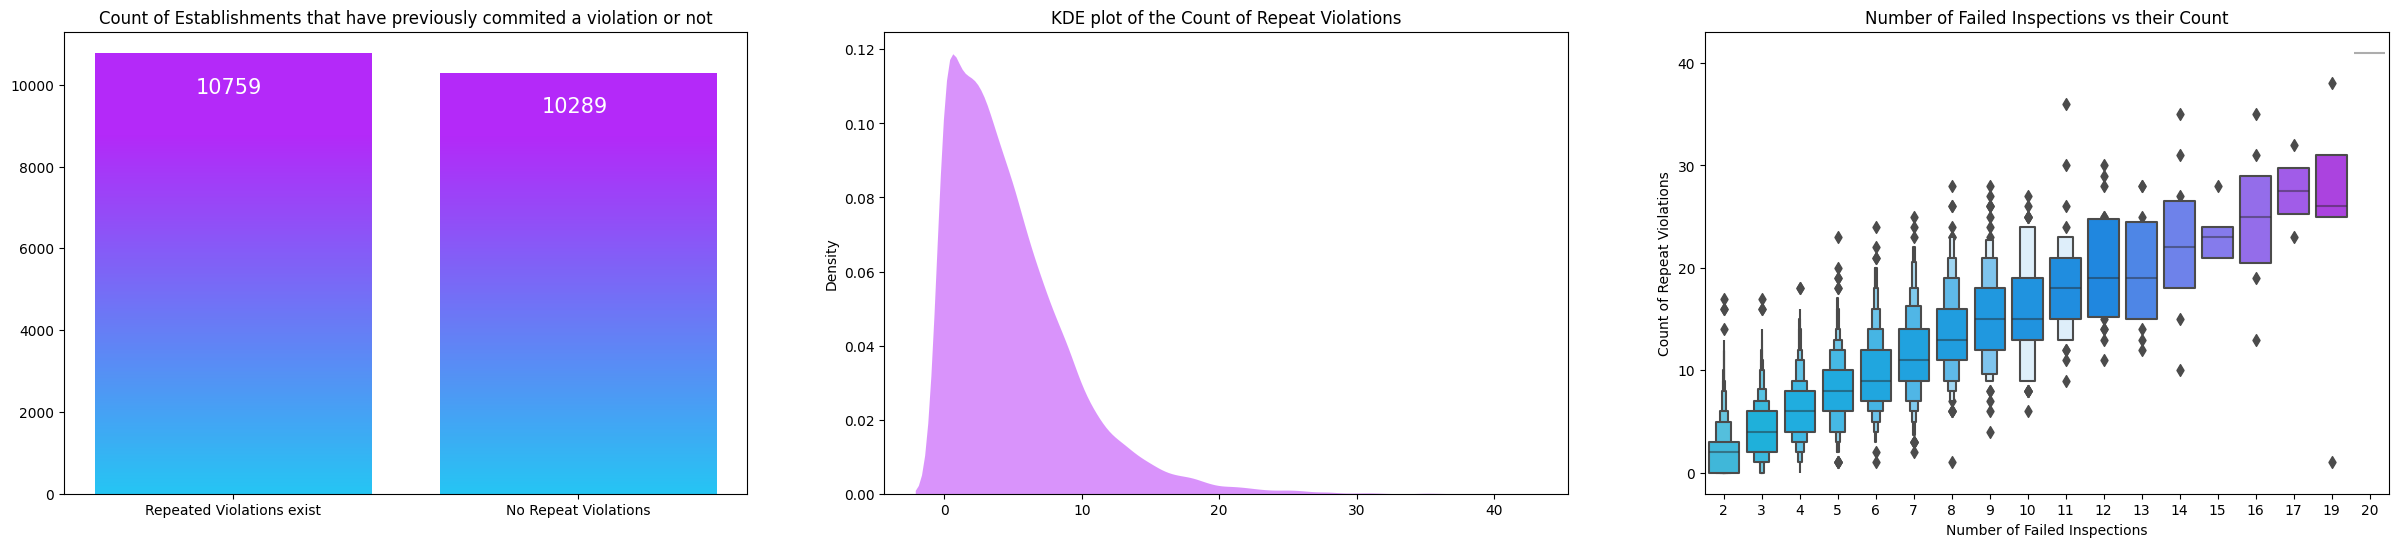

In [25]:
previous_violation_bars = repeat_offender_df["isRepeatViolations"].value_counts().reset_index()
fig,axs = plt.subplots(1,3,figsize=(30,6))
previous_violation_visual = axs[0].bar(previous_violation_bars["isRepeatViolations"],bars["count"])
gradientbarsv(previous_violation_visual,previous_violation_bars["count"].values,make_cmap(["#26c5f3","#b429f9"]))
for p in axs[0].patches:
    axs[0].annotate(f'\n{int(p.get_height())}', (p.get_x()+0.39, p.get_height()), ha='center', va='top', color='white', size=15)
axs[0].set(title='Count of Establishments that have previously commited a violation or not',xlabel="")
hist = sns.kdeplot(data = repeat_offender_df,x="Count of Repeat Violations",ax=axs[1],fill=True, common_norm=False,alpha=.5, linewidth=0,color="#b429f9")
axs[1].set(title='KDE plot of the Count of Repeat Violations',xlabel="")
scatter = sns.boxenplot(data = repeat_offender_df,y="Count of Repeat Violations",x="Number of Failed Inspections",ax=axs[2],palette=("#26c5f3","#00c1f9","#00bcff","#00b8ff","#00b3ff","#00adff","#00a7ff","#00a0ff","#0099ff","#0091ff","#0089ff","#357fff","#5974ff","#7568ff","#8c58ff","#a145ff","#b429f9"))
axs[2].set(title='Number of Failed Inspections vs their Count')

As we can see there are more establishments with Repeat Violations than there are establishments with out Repeat Violations. Moreover the higher the count of repeat violations, the higher the probability that they have failed a high number of inspections.  

### Let us find out whether establishments that went "Out of Business" had a previous history of violations or not.

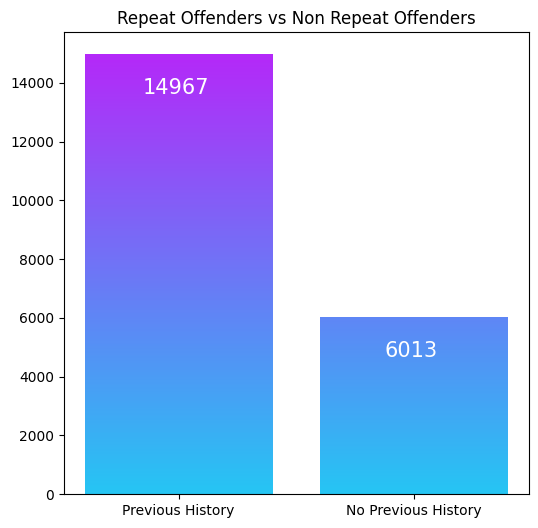

In [26]:
closed_restaurant_data = food_inspection_data[(food_inspection_data["Results"]=="OUT OF BUSINESS")]
closed_grouped = closed_restaurant_data[["Custom Key"]].groupby(["Custom Key"]).count().reset_index()
removed_out_of_business = food_inspection_data[(food_inspection_data["Results"]!="OUT OF BUSINESS")]
food_grouped_data = removed_out_of_business[["Custom Key","Violations"]].groupby(["Custom Key"]).count().reset_index()
closed_merged_data = food_grouped_data.merge(closed_grouped[["Custom Key"]],how="right",on="Custom Key")
closed_merged_data["History"] = closed_merged_data["Violations"].apply(lambda x: "Previous History" if x>0 else "No Previous History")

violation_history_bars = closed_merged_data["History"].value_counts().reset_index()
fig,axs = plt.subplots(1,1,figsize=(6,6))
violation_history_visual = axs.bar(violation_history_bars["History"],violation_history_bars["count"])
gradientbarsv(violation_history_visual,violation_history_bars["count"].values,make_cmap(["#26c5f3","#b429f9"]))
axs.set(title="Repeat Offenders vs Non Repeat Offenders")
for p in axs.patches:
    axs.annotate(f'\n{int(p.get_height())}', (p.get_x()+0.39, p.get_height()), ha='center', va='top', color='white', size=15)

As we can see, a majority of establishments that have gone out of business have had a previous history of violations.

### Let us see how the most common violations have trended over time

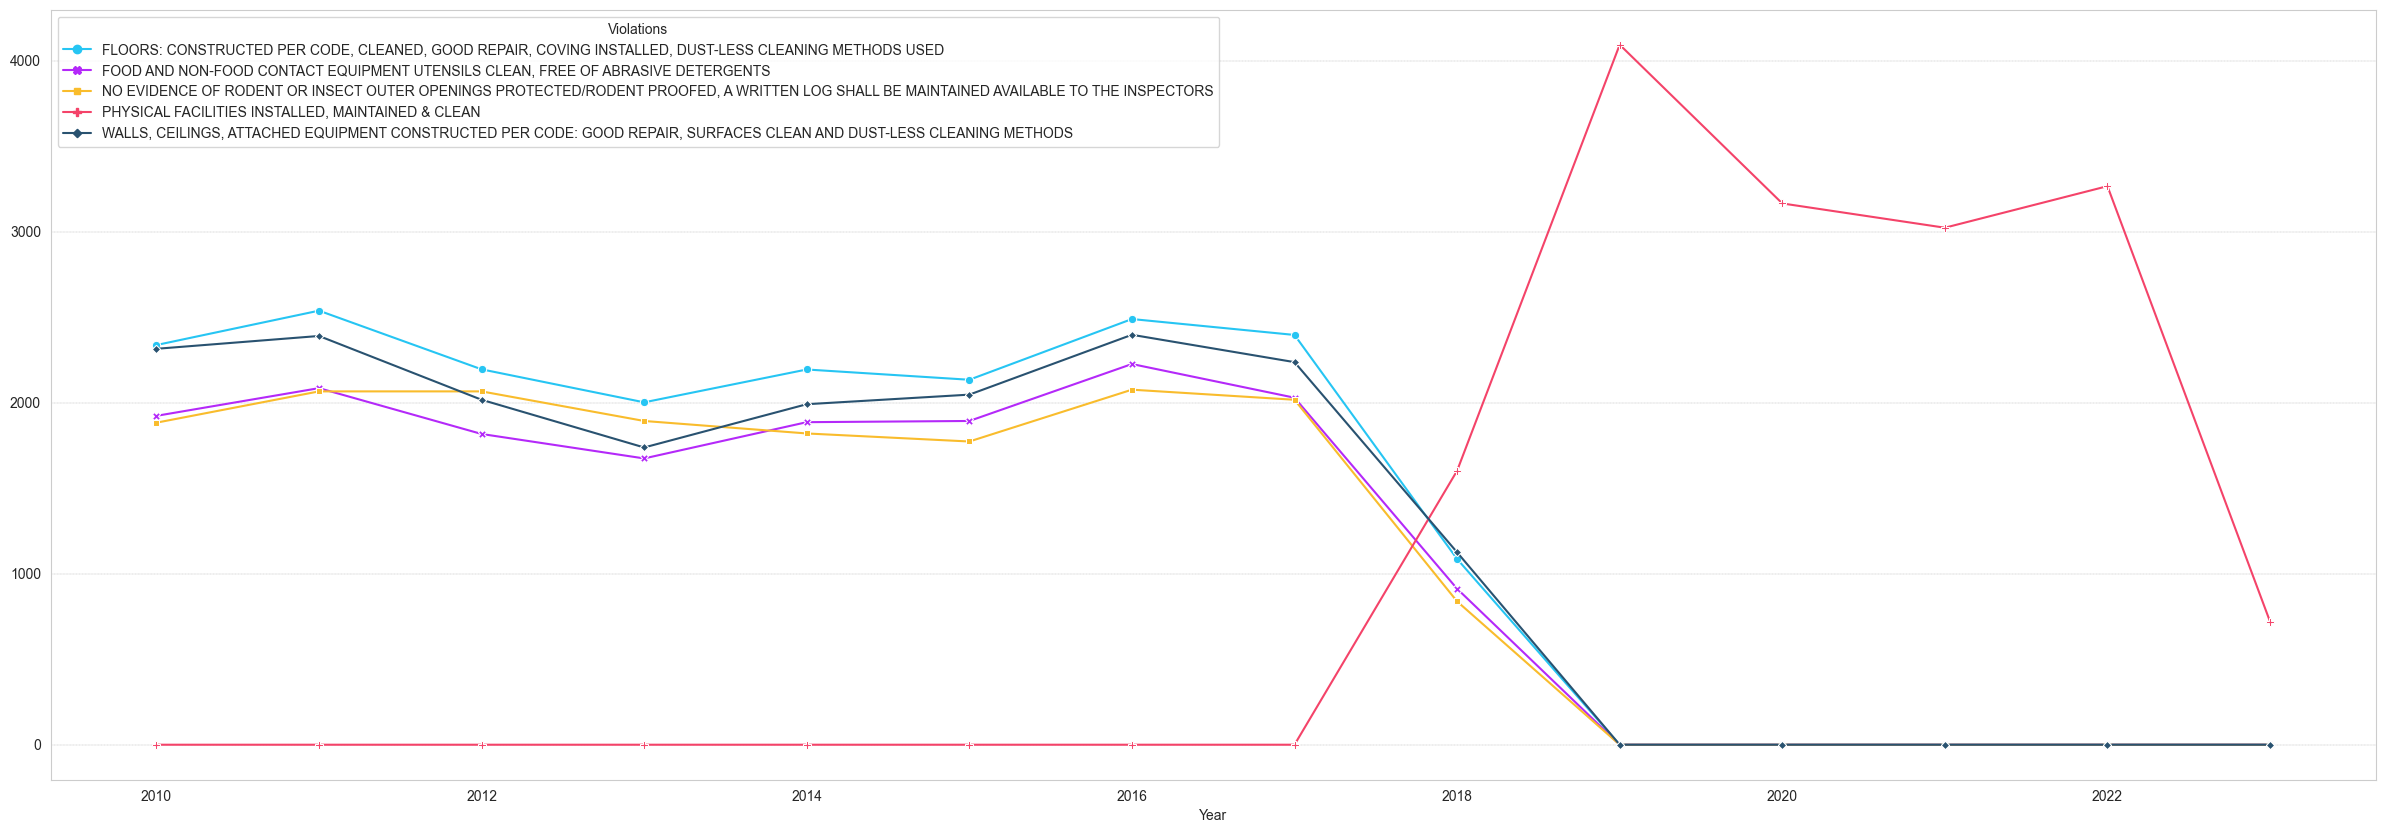

In [45]:
def extract_descriptions_with_na(violation):
    if str(violation) != "nan":
        split_violations = violation.split(sep="|")
        regex_values = []
        pattern = r"(?<=\d\.).*(?= - COMMENTS)"
        for i in split_violations:
            regex = re.search(pattern,i)
            if regex is None:
                string = i.strip()
                string = re.sub(r"(\d{1,3}. )","",string)
                regex_values.append(string)
            else:
                string  = i[regex.start(0):regex.end(0)].strip()
                regex_values.append(string)
        return regex_values
    else:
        return []
description_with_time_extract_df = pd.DataFrame()
description_with_time_extract_df["Violations"] = failed_inspection_data["Violations"].apply(extract_descriptions_with_na)
description_with_time_extract_df["Time"] = failed_inspection_data["Inspection Date"]
description_with_time_extract_df = description_with_time_extract_df.explode("Violations")
description_with_time_extract_df = description_with_time_extract_df[description_with_time_extract_df["Violations"].notna()]
description_with_time_extract_df["Year"] = pd.DatetimeIndex(description_with_time_extract_df['Time']).year
description_with_time_extract_df = description_with_time_extract_df.drop(["Time"],axis=1)
description_extract_agg = pd.DataFrame(description_with_time_extract_df.groupby(["Year","Violations"]).size())
description_extract_agg.reset_index(inplace=True)
selected_violations = description_extract_agg[description_extract_agg["Violations"].isin(top10[:5]["Violations"].values)]
selected_violations.columns = ["Year","Violations","Count"]
selected_violations
selected_violations_pivot = selected_violations.pivot(index="Year",columns="Violations",values="Count")
selected_violations_pivot.fillna(0,inplace=True)
fig,axs = plt.subplots(1,1,figsize=(30,10))
lines = sns.lineplot(data=selected_violations_pivot,ax=axs,palette=("#26C5F3","#B429F9","#f9bc2c","#f44369","#295270"),markers=True, dashes=False)

axs.grid(color = 'grey', linestyle = '--', linewidth = 0.2)
axs.yaxis.grid(True)
axs.xaxis.grid(False)

We can see that, around the year 2017, there was a refresh in the codes used, which is why the previously used codes have trended downward in usage while, the new codes like "PHYSICAL FACILITIES INSTALLED, MAINTAINED & CLEAN" has increased in use since 2018